# **⚙️ Step 0: Setup Environment dan Installasi Library**

In [1]:
# 📌 STEP 0: Persiapan Environment
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install Modul
print("Memulai instalasi modul...\n")

# Hapus instalasi torch, torchvision, torchaudio yang mungkin bermasalah
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip uninstall -y transformers accelerate
!pip install transformers accelerate -U
!pip install Sastrawi pandas scikit-learn matplotlib seaborn wordcloud datasets -U

print("\n--- Instalasi Selesai ---")
print("⚠️ PENTING: Setelah instalasi selesai HARUS me-restart runtime Google Colab sekarang.")
print("   Setelah restart, jalankan semua sel kode mulai dari IMPORTS lagi.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memulai instalasi modul...

Found existing installation: torch 2.7.1+cu118
Uninstalling torch-2.7.1+cu118:
  Successfully uninstalled torch-2.7.1+cu118
Found existing installation: torchvision 0.22.1+cu118
Uninstalling torchvision-0.22.1+cu118:
  Successfully uninstalled torchvision-0.22.1+cu118
Found existing installation: torchaudio 2.7.1+cu118
Uninstalling torchaudio-2.7.1+cu118:
  Successfully uninstalled torchaudio-2.7.1+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_

In [2]:
# 📌 STEP 1: Cek Ketersediaan GPU (CUDA)
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Menggunakan GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Menggunakan CPU")

Menggunakan CPU


In [3]:
# 📌 STEP 2: Import Library yang Dibutuhkan
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import shutil
import gc
from IPython.display import display
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import numpy as np

print("Library berhasil diimpor.")

# Download Resource NLTK
shutil.rmtree('/root/nltk_data/tokenizers/punkt', ignore_errors=True)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Inisialisasi Stemmer dan Stopword Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stopword_remover_factory = StopWordRemoverFactory()

print("Pustaka dan sumber daya awal berhasil diinisialisasi.")


Library berhasil diimpor.
Pustaka dan sumber daya awal berhasil diinisialisasi.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# 📌 STEP 3: Setting Stopword

# Gunakan daftar stopword dari Sastrawi terlebih dahulu dan konversi ke SET
stop_words = set(stopword_remover_factory.get_stop_words())

# --- TAMBAHAN: inisisi stopword lainnya ---
tambahan_stop_words = set([
    'kan', 'sih', 'deh', 'nih', 'aja', 'udah', 'dong', 'pun', 'kok', 'gitu',
    'yang', 'itu', 'ini', 'ada', 'dari', 'dengan', 'untuk', 'dan', 'atau', 'jadi',
    'kalau', 'bisa', 'tidak', 'sudah', 'masih', 'punya', 'ke', 'di', 'pada', 'saat',
    'nya',
    'ya', 'loh', 'kak', 'bang', 'mbak', 'min', 'coy',
    'apa', 'bagaimana', 'kenapa', 'siapa',
    'yg', 'udah', 'udh', 'ga', 'gak', 'tp', 'jd', 'kyk', 'trs',
    'rt', 'via', 'user',
    'gue', 'kayak', 'amp', 'eh', 'duh', 'wah', 'hmm', 'trs',
    'baru', 'terus', 'bukan','orang', 'semua', 'banget', 'mau', 'buat', 'banyak', 'sama','memang', 'lihat',
    'jadi', 'besar', 'lebih', 'baik', 'moga', 'tuju', 'bagus', 'lihat', 'pakai', 'bakal'
])

# Gabungkan daftar stop_words bawaan Sastrawi dengan daftar tambahan
stop_words.update(tambahan_stop_words)
print("Daftar stopwords diperbarui dengan kata-kata informal/spesifik.")


Daftar stopwords diperbarui dengan kata-kata informal/spesifik.


In [5]:
# 📌 STEP 4: Cek Stopword

print("--- Pemeriksaan Daftar Stopword ---")
kata_yang_dicurigai = ['gue', 'kayak', 'amp', 'sih', 'yg', 'ga', 'udh', 'amp']
for kata in kata_yang_dicurigai:
    if kata in stop_words:
        print(f"'{kata}' ditemukan dalam daftar stopword.")
    else:
        print(f"⚠️ '{kata}' TIDAK ditemukan dalam daftar stopword.")


--- Pemeriksaan Daftar Stopword ---
'gue' ditemukan dalam daftar stopword.
'kayak' ditemukan dalam daftar stopword.
'amp' ditemukan dalam daftar stopword.
'sih' ditemukan dalam daftar stopword.
'yg' ditemukan dalam daftar stopword.
'ga' ditemukan dalam daftar stopword.
'udh' ditemukan dalam daftar stopword.
'amp' ditemukan dalam daftar stopword.


In [6]:
class_names_sentiment = ['negative', 'neutral', 'positive'] # Kelas yang digunakan oleh model taufiqdp

In [7]:
# MODEL_NAME = "indolem/indobert-base-uncased"

# **📚 Step 1: Import Data**

In [8]:
# 📌 STEP 1.1: Baca dan Gabungkan Data Tweet dari Google Drive

csv_path_pra = '/content/drive/MyDrive/DATA/danantara_pra.csv'
csv_path_day = '/content/drive/MyDrive/DATA/danantara_day.csv'
csv_path_pasca = '/content/drive/MyDrive/DATA/danantara_pasca.csv'

df_pra = pd.read_csv(csv_path_pra, encoding='utf-8')
df_pra['periode'] = 'pra_peluncuran'
df_pra.info()

df_day = pd.read_csv(csv_path_day, encoding='utf-8')
df_day['periode'] = 'hari_h_peluncuran'
df_day.info()

df_pasca = pd.read_csv(csv_path_pasca, encoding='utf-8')
df_pasca['periode'] = 'pasca_peluncuran'
df_pasca.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3545 entries, 0 to 3544
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      3545 non-null   int64  
 1   created_at               3545 non-null   object 
 2   favorite_count           3545 non-null   int64  
 3   full_text                3545 non-null   object 
 4   id_str                   3545 non-null   int64  
 5   image_url                632 non-null    object 
 6   in_reply_to_screen_name  2135 non-null   object 
 7   lang                     3545 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              3545 non-null   int64  
 10  reply_count              3545 non-null   int64  
 11  retweet_count            3545 non-null   int64  
 12  tweet_url                3545 non-null   object 
 13  user_id_str              3545 non-null   int64  
 14  username                

In [9]:
# 📌 STEP 1.2: Gabungkan semua DataFrame
df = pd.concat([df_pra, df_day, df_pasca], ignore_index=True)

# Ambil kolom penting saja (full_text, created_at, periode, dan kolom untuk analisis buzzer)
required_cols = ['full_text', 'created_at', 'periode', 'in_reply_to_screen_name', 'user_id_str']
# Filter hanya kolom yang benar-benar ada di df
df = df[[col for col in required_cols if col in df.columns]]

df.dropna(subset=['full_text', 'created_at'], inplace=True) # Hapus baris kosong di kolom penting
df.drop_duplicates(subset='full_text', keep='first', inplace=True) # Hapus duplikat
df.reset_index(drop=False, inplace=True) # Simpan index asli sebagai kolom 'index'

df['created_at'] = pd.to_datetime(df['created_at'])

print("\n✅ STEP 1.2 (Baca dan Gabungkan Data):")
print("\nInfo DataFrame:")
df.info()
print("\n5 baris pertama:")
print(df.head())
print(f"\nTotal data setelah penggabungan & deduplikasi: {len(df)} baris.")


/tmp/ipython-input-9-1328288368.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])



✅ STEP 1.2 (Baca dan Gabungkan Data):

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11240 entries, 0 to 11239
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   index                    11240 non-null  int64              
 1   full_text                11240 non-null  object             
 2   created_at               11240 non-null  datetime64[ns, UTC]
 3   periode                  11240 non-null  object             
 4   in_reply_to_screen_name  5914 non-null   object             
 5   user_id_str              11240 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(3)
memory usage: 527.0+ KB

5 baris pertama:
   index                                          full_text  \
0      0  sbg manusia newbie yg baru nyemplung ke dunia ...   
1      1  @CNNIndonesia @CNNIndonesia makanya beritain k...   
2      2     

In [10]:
# 📌 STEP 7: Cek Tanggal Unik
print("\n✅ STEP 7: Mengecek tanggal unik pada data...")

# Pastikan kolom 'created_at' adalah datetime
if not pd.api.types.is_datetime64_any_dtype(df['created_at']):
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    print("Kolom 'created_at' dikonversi ke tipe datetime.")

# Ekstrak tanggal saja dan dapatkan nilai unik
unique_dates = df['created_at'].dt.date.unique()

print(f"Jumlah tanggal unik: {len(unique_dates)}")
print("\nDaftar tanggal unik:")
# Cetak tanggal unik dalam format yang lebih mudah dibaca
for date in sorted(unique_dates):
    print(date)

print("\n✅ STEP 7: Pengecekan tanggal unik selesai.")


✅ STEP 7: Mengecek tanggal unik pada data...
Jumlah tanggal unik: 12

Daftar tanggal unik:
2025-02-19
2025-02-20
2025-02-21
2025-02-22
2025-02-24
2025-02-26
2025-02-27
2025-05-26
2025-05-27
2025-05-28
2025-05-29
2025-05-30

✅ STEP 7: Pengecekan tanggal unik selesai.


# **🧹: Step 2: Data Preprocessing**

In [11]:
# 📌 STEP 2.1: Identifikasi dan Hapus Buzzer (Langsung)

initial_data_count = len(df)

# --- Strategi 1: Hapus berdasarkan hashtag spesifik ---
hashtags_to_remove = ['#GerakCepatEkonomiHebat', '#DanantaraPorosInvestasi', '#DanantaraUntukBangsa', '#BangkitBersamaDanantara', '#InvestasiNasional',
                      '#InvestasiHijau', '#DanantaraBangunNegeri']

# Buat pola regex untuk mencocokkan salah satu hashtag dalam list
hashtag_pattern = '|'.join([re.escape(tag) for tag in hashtags_to_remove])

df = df[~df['full_text'].str.contains(hashtag_pattern, case=False, na=False)]
deleted_count_hashtag = initial_data_count - len(df)
print(f"Jumlah tweet dihapus karena hashtag '{hashtags_to_remove}': {deleted_count_hashtag} baris.")
initial_data_count = len(df) # Update count setelah penghapusan hashtag

# --- Strategi 2: Hapus berdasarkan akun yang paling sering dibalas/disebut (potensi target buzzer) ---
if 'in_reply_to_screen_name' in df.columns:
    reply_counts = df['in_reply_to_screen_name'].value_counts().reset_index()
    reply_counts.columns = ['screen_name', 'reply_count']
    print("\n\nTop replied-to screen names (untuk identifikasi manual akun target/buzzer):")
    display(reply_counts.head(10))

    # >>> IDENTIFIKASI AKUN BUZZER SECARA MANUAL DARI OUTPUT DI ATAS <<<
    buzzer_target_screen_names = ['JedTeguh03','reaareaa__', 'GenZNusantara', 'RantaiPersatuan', 'FrediRanti4', 'RahmahSeikha','LeonPriceleon48',
                                  'yaniarsim', 'KangManto123', 'TOM5helby', 'Alivianytaa22','msaid_didu', 'BosPurwa',
                                  'NenkMonica', 'shaljuy', 'yudhakhel', 'geloraco', 'JhonSitorus_18', 'Boediantar4'] # <-- SESUAIKAN DENGAN TEMUAN DARI OUTPUT DI ATAS

    if not df['in_reply_to_screen_name'].isnull().all(): # Pastikan kolom tidak kosong semua
        df = df[~df['in_reply_to_screen_name'].isin(buzzer_target_screen_names)]
        deleted_count_reply = initial_data_count - len(df)
        print(f"Jumlah tweet dihapus karena menanggapi akun target/buzzer: {deleted_count_reply} baris.")
        initial_data_count = len(df) # Update count

# --- Strategi 3: Hapus berdasarkan user_id_str yang sangat aktif (potensi akun buzzer pengirim) ---
if 'user_id_str' in df.columns and not df['user_id_str'].isnull().all():
    # Ubah user_id_str ke string untuk penanganan yang lebih baik jika ada tipe data campuran
    df['user_id_str'] = df['user_id_str'].astype(str)

    # Identifikasi user_id_str yang paling sering nge-tweet
    user_id_counts = df['user_id_str'].value_counts().reset_index()
    user_id_counts.columns = ['user_id_str', 'tweet_count']
    print("\n\n\nTop user_id_str by tweet count (untuk identifikasi manual potensi akun buzzer pengirim):")
    display(user_id_counts.head(10))

    # >>> IDENTIFIKASI USER_ID_STR BUZZER DI SINI SECARA MANUAL DARI OUTPUT DI ATAS <<<
    buzzer_sender_user_ids = [] # <-- ISI DAFTAR INI DENGAN USER_ID_STR YANG ANDA CURIGAI

    # Hapus tweet yang dikirim oleh user_id_str yang teridentifikasi sebagai buzzer
    if buzzer_sender_user_ids: # Hanya hapus jika daftar tidak kosong
        df = df[~df['user_id_str'].isin(buzzer_sender_user_ids)]
        deleted_count_sender = initial_data_count - len(df)
        print(f"Jumlah tweet dihapus dari akun pengirim buzzer: {deleted_count_sender} baris.")
        initial_data_count = len(df)

# Reset index setelah semua penghapusan
df.reset_index(drop=False, inplace=True)

print(f"\n✅ STEP 2.1 (Identifikasi dan Hapus Buzzer Selesai):")
print(f"Total data setelah semua penghapusan terkait buzzer: {len(df)} baris.")


Jumlah tweet dihapus karena hashtag '['#GerakCepatEkonomiHebat', '#DanantaraPorosInvestasi', '#DanantaraUntukBangsa', '#BangkitBersamaDanantara', '#InvestasiNasional', '#InvestasiHijau', '#DanantaraBangunNegeri']': 1772 baris.


Top replied-to screen names (untuk identifikasi manual akun target/buzzer):


,screen_name,reply_count
0,reaareaa__,553
1,JedTeguh03,452
2,GenZNusantara,391
3,RantaiPersatuan,192
4,RahmahSeikha,155
5,tempodotco,123
6,LeonPriceleon48,95
7,yaniarsim,80
8,KangManto123,57
9,kompascom,52


Jumlah tweet dihapus karena menanggapi akun target/buzzer: 2408 baris.



Top user_id_str by tweet count (untuk identifikasi manual potensi akun buzzer pengirim):


,user_id_str,tweet_count
0,1.562950188343255e+18,44
1,118365034.0,37
2,18129942.0,33
3,67281504.0,26
4,8.473725428304445e+17,25
5,1.648257762865074e+18,23
6,1.8505798124670525e+18,17
7,135795460.0,17
8,89877164.0,17
9,1.8924945970767007e+18,17



✅ STEP 2.1 (Identifikasi dan Hapus Buzzer Selesai):
Total data setelah semua penghapusan terkait buzzer: 7060 baris.


In [12]:
# 📌 STEP 2.2: Baca Kamus Kata Tidak Baku

kamus_path = '/content/drive/MyDrive/DATA/kamuskatabaku.xlsx'
kamus_data = pd.read_excel(kamus_path)
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))


In [13]:
# 📌 STEP 2.3: Bersihkan Simbol, URL, Angka, Hashtag, dsb.
def tahap1_clean(text):
    if not isinstance(text, str): # Pastikan input adalah string
        return ""
    text = re.sub(r"http\S+|www\S+|pic\.twitter\S+", "", text) # hapus URL
    text = re.sub(r"@\w+|#\w+", "", text) # hapus mention dan hashtag
    text = re.sub(r"[^a-zA-Z\s]", " ", text) # hapus simbol dan angka (perbaikan regex)
    text = re.sub(r'\d+', '', text) # Pastikan angka dihapus jika belum oleh regex sebelumnya
    text = re.sub(r'\s+', ' ', text).strip() # Ganti banyak spasi dengan satu dan trim
    return text

df['step_1_clean'] = df['full_text'].apply(tahap1_clean)
print("\n✅ STEP 2.3 (bersih simbol/url/angka):")
df[['full_text', 'step_1_clean']].head()



✅ STEP 2.3 (bersih simbol/url/angka):


,full_text,step_1_clean
0,sbg manusia newbie yg baru nyemplung ke dunia ...,sbg manusia newbie yg baru nyemplung ke dunia ...
1,@CNNIndonesia @CNNIndonesia makanya beritain k...,makanya beritain kabarkan yg benar yg objektif...
2,@tanyarlfes Hati hati,Hati hati
3,@democrazymedia Kami tidak peduli yang di dala...,Kami tidak peduli yang di dalam garis pantai i...
4,Sebelum Kabur Aja Dulu Coba Tiktok Affiliate (...,Sebelum Kabur Aja Dulu Coba Tiktok Affiliate A...


In [14]:
# 📌 STEP 2.4: Ubah ke Huruf Kecil (Lowercase)
df['step_2_lower'] = df['step_1_clean'].str.lower()
print("\n✅ STEP 2.4 (lowercase):")
df[['step_1_clean', 'step_2_lower']].head()



✅ STEP 2.4 (lowercase):


,step_1_clean,step_2_lower
0,sbg manusia newbie yg baru nyemplung ke dunia ...,sbg manusia newbie yg baru nyemplung ke dunia ...
1,makanya beritain kabarkan yg benar yg objektif...,makanya beritain kabarkan yg benar yg objektif...
2,Hati hati,hati hati
3,Kami tidak peduli yang di dalam garis pantai i...,kami tidak peduli yang di dalam garis pantai i...
4,Sebelum Kabur Aja Dulu Coba Tiktok Affiliate A...,sebelum kabur aja dulu coba tiktok affiliate a...


In [15]:
# 📌 STEP 2.5: Normalisasi Kata Tidak Baku (Kamus)
def tahap3_normalize(text):
    return ' '.join([kamus_tidak_baku[word] if word in kamus_tidak_baku else word for word in text.split()])

df['step_3_normal'] = df['step_2_lower'].apply(tahap3_normalize)
print("\n✅ STEP 2.5 (normalisasi):")
df[['step_2_lower', 'step_3_normal']].head()



✅ STEP 2.5 (normalisasi):


,step_2_lower,step_3_normal
0,sbg manusia newbie yg baru nyemplung ke dunia ...,sebagai manusia newbie yang baru nyemplung ke ...
1,makanya beritain kabarkan yg benar yg objektif...,makanya beritain kabarkan yang benar yang obje...
2,hati hati,hati hati
3,kami tidak peduli yang di dalam garis pantai i...,kami tidak peduli yang di dalam garis pantai i...
4,sebelum kabur aja dulu coba tiktok affiliate a...,sebelum kabur saja dulu coba tiktok affiliate ...


In [16]:
# --- Definisikan path untuk file cache hasil pra-pemrosesan clean_text ---
clean_text_cache_path = '/content/drive/MyDrive/DATA/danantara_clean_text_preprocessed_cache.csv'


# Fungsi untuk melakukan preprocessing lanjutan (tokenisasi, stopword, stemming)
def apply_advanced_preprocessing_global(dataframe, stemmer_obj, stop_words_set):
    df_copy = dataframe.copy()
    df_copy['step_4_token'] = df_copy['step_3_normal'].apply(lambda x: word_tokenize(str(x)))
    df_copy['step_5_stopword'] = df_copy['step_4_token'].apply(lambda tokens: [word for word in tokens if word not in stop_words_set and len(word) > 2])
    df_copy['step_6_stemmed'] = df_copy['step_5_stopword'].apply(lambda tokens: [stemmer_obj.stem(word) for word in tokens])
    df_copy['clean_text'] = df_copy['step_6_stemmed'].apply(lambda tokens: ' '.join(tokens))
    return df_copy

# Lakukan preprocessing lanjutan secara global (sekali) untuk seluruh df
print("\n✅ STEP 2.6: Menghitung clean_text untuk seluruh dataset (sekali).")

is_clean_text_loaded = False # Flag untuk melacak apakah data sudah berhasil dimuat dari cache

if os.path.exists(clean_text_cache_path):
    print("Memuat data pra-pemrosesan (clean_text) dari file cache...")
    try:
        # Muat DataFrame dari file cache. Ini akan menggantikan 'df' yang ada.
        df_loaded_from_cache = pd.read_csv(clean_text_cache_path, encoding='utf-8')

        # Verifikasi minimal: pastikan 'clean_text' dan kolom penting lainnya ada
        required_cols_for_clean_text_cache = ['full_text', 'clean_text', 'step_3_normal']
        if all(col in df_loaded_from_cache.columns for col in required_cols_for_clean_text_cache):
            df = df_loaded_from_cache # Ganti df utama dengan yang dari cache
            is_clean_text_loaded = True
            print("Data pra-pemrosesan (clean_text) berhasil dimuat dari file cache.")
        else:
            print("Peringatan: File cache clean_text tidak mengandung semua kolom yang diperlukan. Akan melanjutkan dengan pra-pemrosesan ulang.")
            os.remove(clean_text_cache_path) # Hapus cache yang mungkin rusak

    except Exception as e:
        print(f"Error memuat file cache clean_text: {e}. Akan melanjutkan dengan pra-pemrosesan ulang.")
        if os.path.exists(clean_text_cache_path):
            os.remove(clean_text_cache_path)

# Jika data clean_text belum dimuat dari cache, jalankan proses preprocessing
if not is_clean_text_loaded:
    # Pada titik ini, 'df' seharusnya sudah terisi dari langkah-langkah sebelumnya (hingga step_3_normal)
    print("Menghitung clean_text untuk seluruh dataset.")
    df = apply_advanced_preprocessing_global(df, stemmer, stop_words) # Gunakan stemmer dan stop_words global
    print("Clean_text untuk seluruh DataFrame berhasil dibuat.")

    # Simpan hasil pra-pemrosesan ke file cache
    df.to_csv(clean_text_cache_path, index=False, encoding='utf-8')
    print(f"Hasil pra-pemrosesan (clean_text) disimpan ke cache: {clean_text_cache_path}")

print("\n5 baris pertama dengan clean_text:")
df[['full_text', 'clean_text']].head()



✅ STEP 2.6: Menghitung clean_text untuk seluruh dataset (sekali).
Memuat data pra-pemrosesan (clean_text) dari file cache...
Data pra-pemrosesan (clean_text) berhasil dimuat dari file cache.

5 baris pertama dengan clean_text:


,full_text,clean_text
0,sbg manusia newbie yg baru nyemplung ke dunia ...,manusia newbie nyemplung dunia accounting bila...
1,@CNNIndonesia @CNNIndonesia makanya beritain k...,makanya beritain kabar benar objektif transpar...
2,@tanyarlfes Hati hati,hati hati
3,@democrazymedia Kami tidak peduli yang di dala...,peduli garis pantai garis pantai shgb milik sa...
4,Sebelum Kabur Aja Dulu Coba Tiktok Affiliate (...,kabur dulu coba tiktok affiliate thread tiktok...


# **📝 Step 3: Pelabelan Sentimen menggunakan Hugging Face Transformers**

In [17]:
# 📌 STEP 3.1: Pelabelan Sentimen menggunakan Hugging Face Transformers (untuk mendapatkan label awal) ---

# --- Definisikan path untuk file cache hasil pelabelan ---
labeled_data_cache_path = '/content/drive/MyDrive/DATA/danantara_labeled_by_pretrained_bert.csv'

# --- Perbaikan: Cek apakah file hasil pelabelan sudah ada ---
is_labeled_data_loaded = False # Flag untuk melacak apakah data sudah berhasil dimuat dari cache

if os.path.exists(labeled_data_cache_path):
    print("✅ STEP 3.1: Memuat label sentimen dari file cache...")
    try:
        # Muat seluruh DataFrame dari file cache
        df_loaded_from_cache = pd.read_csv(labeled_data_cache_path, encoding='utf-8')

        # Verifikasi kolom-kolom esensial yang dibutuhkan untuk langkah selanjutnya sudah ada
        # Misalnya, 'full_text', 'clean_text', 'step_3_normal', 'sentiment_label'
        required_cols_after_step_8 = ['full_text', 'clean_text', 'step_3_normal', 'sentiment_label']

        if all(col in df_loaded_from_cache.columns for col in required_cols_after_step_8):
            # Jika semua kolom penting ada, ganti df utama dengan df dari cache
            # Ini mengasumsikan df dari langkah sebelumnya akan diganti.
            df = df_loaded_from_cache
            is_labeled_data_loaded = True
            print("Label sentimen berhasil dimuat dari file cache.")
        else:
            print("Peringatan: File cache tidak mengandung semua kolom yang diperlukan. Akan melanjutkan dengan pelabelan ulang.")
            # Hapus file yang mungkin rusak agar tidak dipakai lagi
            os.remove(labeled_data_cache_path)

    except Exception as e:
        print(f"Error memuat file cache: {e}. Akan melanjutkan dengan pelabelan ulang.")
        if os.path.exists(labeled_data_cache_path):
            os.remove(labeled_data_cache_path)

# Jika data belum berhasil dimuat dari cache (is_labeled_data_loaded masih False),
# maka jalankan proses pelabelan dari awal
if not is_labeled_data_loaded:
    # Pada titik ini, 'df' seharusnya masih berisi DataFrame dari langkah-langkah preprocessing sebelumnya.
    # Proses pelabelan akan menambahkan kolom 'sentiment_label' ke 'df' ini.
    print("\nMemuat tokenizer dan model sentimen IndoBERT pra-terlatih (untuk mendapatkan label awal)...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan perangkat: {device}")

    # Menggunakan model taufiqdp/indonesian-sentiment untuk pelabelan awal
    tokenizer_initial = AutoTokenizer.from_pretrained("taufiqdp/indonesian-sentiment")
    model_initial = AutoModelForSequenceClassification.from_pretrained("taufiqdp/indonesian-sentiment").to(device)

    def predict_sentiment_indobert_initial(text):
        if pd.isna(text) or text == '':
            return 'neutral'
        # Tokenisasi input
        inputs = tokenizer_initial(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Prediksi sentimen
        with torch.no_grad():
            outputs = model_initial(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        return class_names_sentiment[predictions.item()]

    print("\nMenerapkan prediksi sentimen dengan IndoBERT pra-terlatih untuk mendapatkan label...")
    # Menggunakan 'step_3_normal' sebagai input ke model BERT
    df['sentiment_label'] = df['step_3_normal'].apply(predict_sentiment_indobert_initial)
    print("Pelabelan sentimen dengan IndoBERT pra-terlatih selesai.")

    # Simpan hasil pelabelan ke file cache
    # Simpan seluruh df dengan label baru. Ini memastikan semua kolom preprocessing juga tersimpan.
    df.to_csv(labeled_data_cache_path, index=False, encoding='utf-8')
    print(f"Hasil pelabelan sentimen disimpan ke cache: {labeled_data_cache_path}")

# Bagian ini akan selalu berjalan setelah 'df' memiliki kolom 'sentiment_label',
# baik itu dari cache maupun hasil pelabelan baru
print("\nDistribusi Sentimen (Label dari IndoBERT pra-terlatih):")
print(df['sentiment_label'].value_counts())

print("\n10 baris pertama dengan sentimen yang diprediksi oleh IndoBERT pra-terlatih:")
df[['full_text', 'clean_text', 'step_3_normal', 'sentiment_label']].head(10)

✅ STEP 3.1: Memuat label sentimen dari file cache...
Label sentimen berhasil dimuat dari file cache.

Distribusi Sentimen (Label dari IndoBERT pra-terlatih):
sentiment_label
negative    3138
neutral     2639
positive    1283
Name: count, dtype: int64

10 baris pertama dengan sentimen yang diprediksi oleh IndoBERT pra-terlatih:


,full_text,clean_text,step_3_normal,sentiment_label
0,sbg manusia newbie yg baru nyemplung ke dunia ...,manusia newbie nyemplung dunia accounting bila...,sebagai manusia newbie yang baru nyemplung ke ...,positive
1,@CNNIndonesia @CNNIndonesia makanya beritain k...,makanya beritain kabar benar objektif transpar...,makanya beritain kabarkan yang benar yang obje...,negative
2,@tanyarlfes Hati hati,hati hati,hati hati,positive
3,@democrazymedia Kami tidak peduli yang di dala...,peduli garis pantai garis pantai shgb milik sa...,kami tidak peduli yang di dalam garis pantai i...,negative
4,Sebelum Kabur Aja Dulu Coba Tiktok Affiliate (...,kabur dulu coba tiktok affiliate thread tiktok...,sebelum kabur saja dulu coba tiktok affiliate ...,positive
5,@KoranBUMN @KemenBUMN @KemenPU @kementan @eric...,danantara tuju tingkat kerjasama nasional bumn...,danantara ditujukan untuk meningkatkan kerjasa...,neutral
6,Mau tidak mau harus mengakui bahwa bangsa ini ...,aku bangsa kurang pintar jujur danantara kelol...,mau tidak mau harus mengakui bahwa bangsa ini ...,negative
7,@innovacommunity Engak rakyat enggak pejabat s...,engak rakyat enggak jabat indonesia emas,engak rakyat enggak pejabat sama saja indonesi...,negative
8,Klo membaca ulasan bu Sik Tifa.. Apalagi mmbac...,baca ulas sik tifa mmbaca inonesia tbk dananta...,kalau membaca ulasan bu sik tifa apalagi mmbac...,negative
9,@Gunawan75_ 1 kata ; LEBAY program efisiensi t...,kata lebay program efisiensi nyata kabinet gem...,kata lebay program efisiensi ternyata kabinet ...,neutral


# **📊 Step 4: Visualisasi Distribusi Sentimen**


✅ STEP 4.1: Membuat Diagram Distribusi Sentimen...


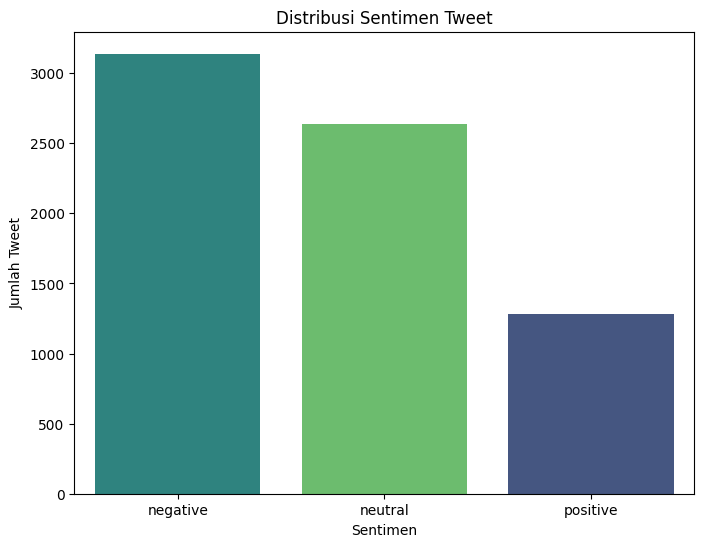

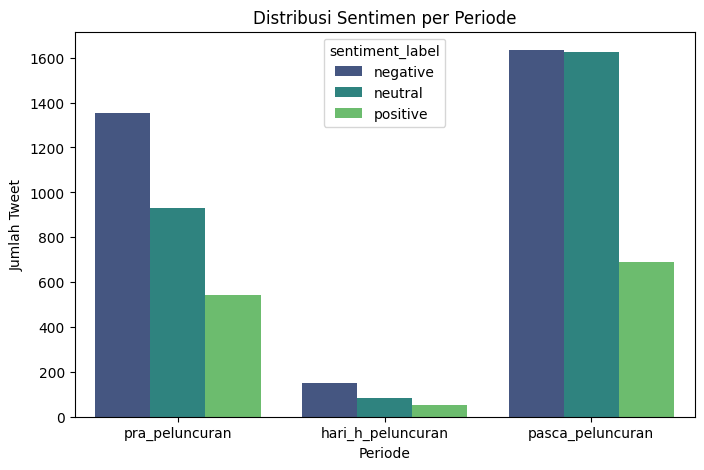

Distribusi sentimen per periode berhasil dibuat.


In [18]:
# --- BAGIAN VISUALISASI ---

# 📌 STEP 4.1: Visualisasi Distribusi Sentimen (Diagram Batang)
print("\n✅ STEP 4.1: Membuat Diagram Distribusi Sentimen...")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=df, hue='sentiment_label', palette='viridis', order=class_names_sentiment, legend=False)
plt.title('Distribusi Sentimen Tweet')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet')
plt.show()

# Distribusi sentimen per periode
# Pastikan kolom 'periode' ada di df Anda
periode_order = ['pra_peluncuran', 'hari_h_peluncuran', 'pasca_peluncuran']
if 'periode' in df.columns:
    unique_periods = [p for p in periode_order if p in df['periode'].unique()] # Filter periode yang benar-benar ada
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x='periode', hue='sentiment_label', order=periode_order, hue_order=class_names_sentiment, palette="viridis")
    plt.title('Distribusi Sentimen per Periode')
    plt.xlabel("Periode")
    plt.ylabel("Jumlah Tweet")
    plt.show()
    print("Distribusi sentimen per periode berhasil dibuat.")
else:
    print("Kolom 'periode' tidak ditemukan di DataFrame. Tidak dapat membuat visualisasi per periode.")



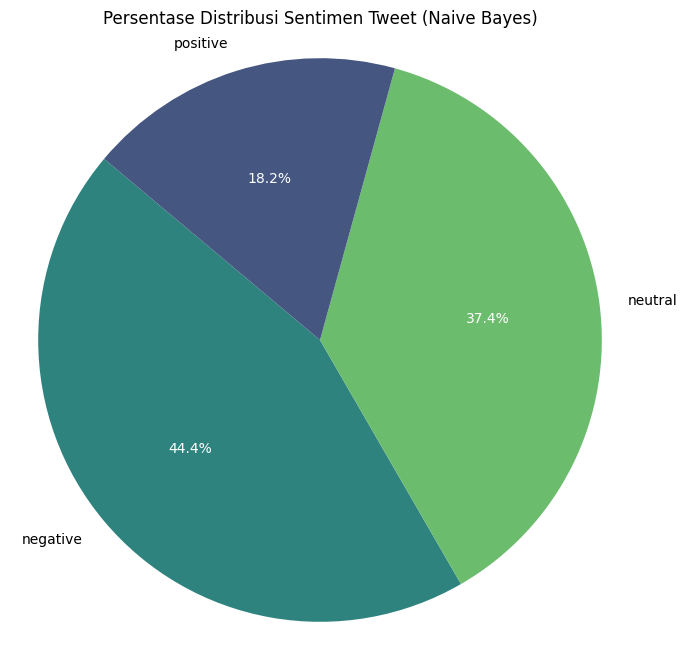


✅ STEP 4.1 (Lanjutan): Pembuatan Pie Chart selesai.


In [19]:
# 📌 STEP 4.1 (Lanjutan): Visualisasi Distribusi Sentimen (Pie Chart)

# Hitung jumlah masing-masing sentimen
sentiment_counts = df['sentiment_label'].value_counts()

# Urutkan berdasarkan urutan yang diinginkan (negatif, netral, positif)
ordered_sentiment_counts = sentiment_counts.reindex(class_names_sentiment)

# Menggunakan warna hex yang spesifik sesuai permintaan user
colors = ['#2f837f', '#6cbc6e', '#455681'] # Urutan: negative, neutral, positive

plt.figure(figsize=(8, 8))
# plt.pie returns a tuple of (patches, texts, autotexts)
# patches are the wedges, texts are the external labels, autotexts are the internal percentages
patches, texts, autotexts = plt.pie(ordered_sentiment_counts, labels=ordered_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Set color of internal percentage text to white
for text in autotexts:
    text.set_color('white')

plt.title('Persentase Distribusi Sentimen Tweet (Naive Bayes)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print("\n✅ STEP 4.1 (Lanjutan): Pembuatan Pie Chart selesai.")


✅ STEP 4.2: Membuat Word Cloud...


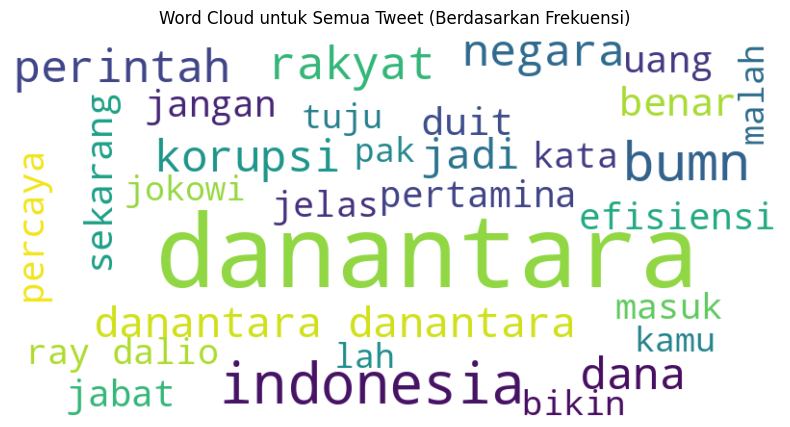

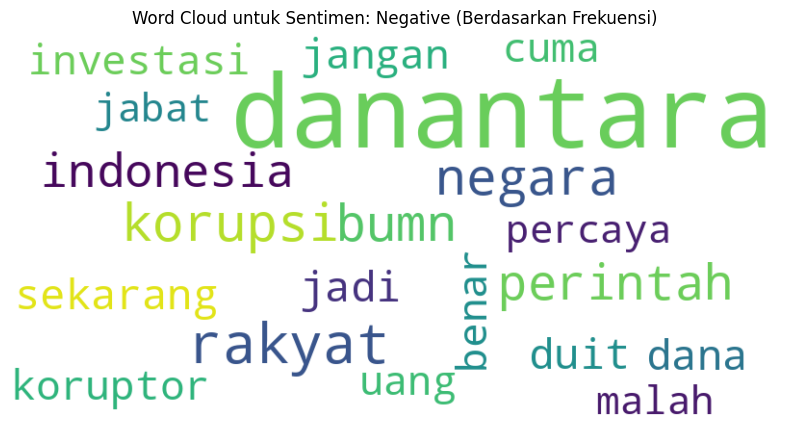

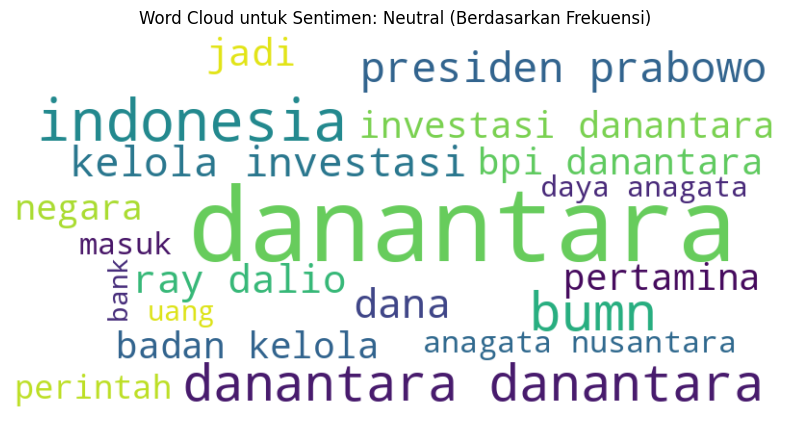

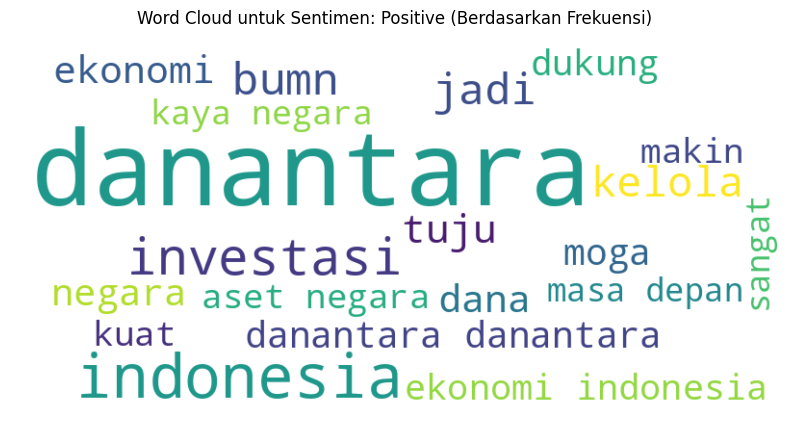

Word Cloud berhasil dibuat untuk semua sentimen dan per kategori.


In [20]:
# 📌 STEP 4.2: Word Cloud untuk Semua Sentimen (dengan Frekuensi, Minimalisasi Duplikasi Visual)
print("\n✅ STEP 4.2: Membuat Word Cloud...")

# Kumpulkan semua kata dari 'clean_text' di seluruh DataFrame (mempertahankan frekuensi)
all_words_str = ' '.join([text for text in df['clean_text'] if pd.notna(text)])

if all_words_str: # Pastikan ada teks untuk di-generate word cloud
    # max_words disesuaikan untuk menampilkan lebih banyak kata unik
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=30).generate(all_words_str)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud untuk Semua Tweet (Berdasarkan Frekuensi)')
    plt.show()
else:
    print("Tidak ada teks untuk membuat Word Cloud keseluruhan.")

# Word Cloud per Kategori Sentimen (dengan Frekuensi, Minimalisasi Duplikasi Visual)
for sentiment_cat in class_names_sentiment:
    sentiment_all_words_str = ' '.join([text for text in df[df['sentiment_label'] == sentiment_cat]['clean_text'] if pd.notna(text)])

    if sentiment_all_words_str: # Hanya buat word cloud jika ada teks untuk sentimen tersebut
        wordcloud_sentiment = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(sentiment_all_words_str)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_sentiment, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud untuk Sentimen: {sentiment_cat.capitalize()} (Berdasarkan Frekuensi)')
        plt.show()
    else:
        print(f"Tidak ada teks untuk sentimen '{sentiment_cat}' untuk membuat Word Cloud.")

print("Word Cloud berhasil dibuat untuk semua sentimen dan per kategori.")



✅ STEP 4.3: Membuat Word Cloud per Periode...


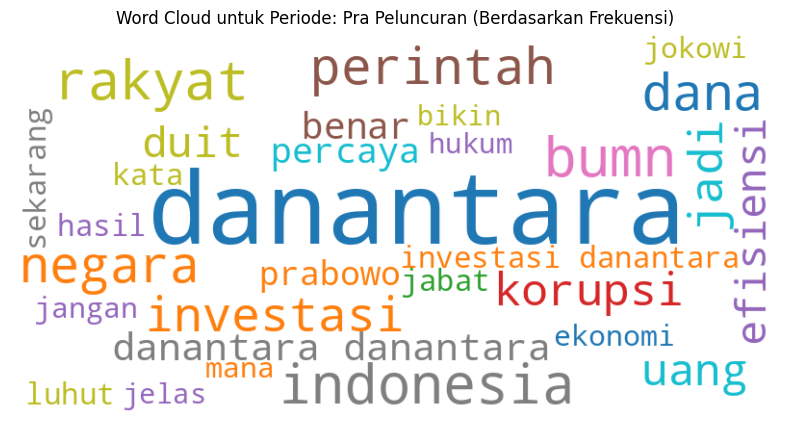

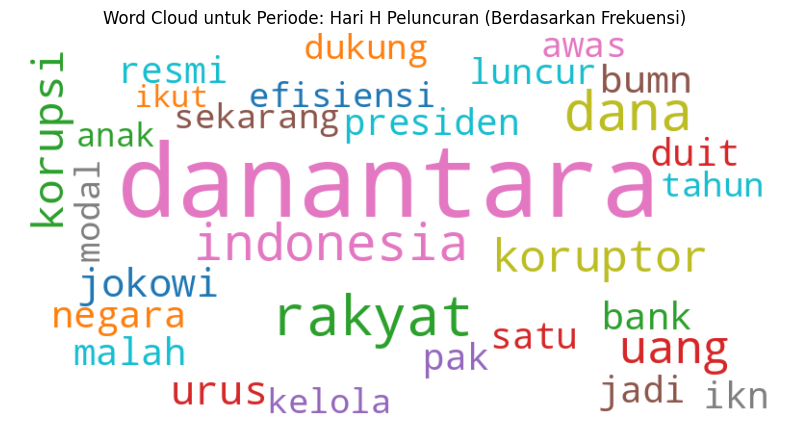

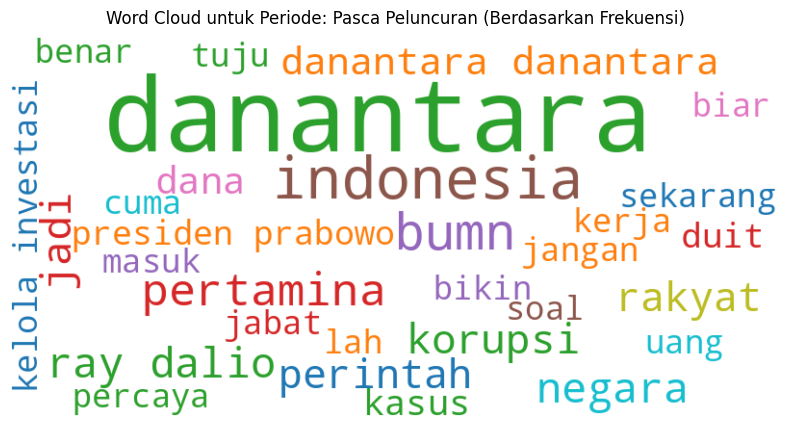

Word Cloud per Periode berhasil dibuat.


In [21]:
# 📌 STEP 4.3: Word Cloud per Periode (dengan Frekuensi, Minimalisasi Duplikasi Visual)
print("\n✅ STEP 4.3: Membuat Word Cloud per Periode...")
if 'periode' in df.columns:
    periode_order = ['pra_peluncuran', 'hari_h_peluncuran', 'pasca_peluncuran']
    unique_periods = [p for p in periode_order if p in df['periode'].unique()]

    for period in unique_periods:
        # Kumpulkan semua kata dari 'clean_text' di periode ini (mempertahankan frekuensi)
        period_all_words_str = ' '.join([text for text in df[df['periode'] == period]['clean_text'] if pd.notna(text)])

        if period_all_words_str:
            wordcloud_period = WordCloud(width=800, height=400, background_color='white', max_words=30, colormap=plt.cm.tab10).generate(period_all_words_str)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud_period, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud untuk Periode: {period.replace("_", " ").title()} (Berdasarkan Frekuensi)')
            plt.show()
        else:
            print(f"Tidak ada teks untuk membuat Word Cloud keseluruhan di periode '{period}'.")
    print("Word Cloud per Periode berhasil dibuat.")
else:
    print("Kolom 'periode' tidak ditemukan di DataFrame. Lewati visualisasi per periode.")


# **🧠 Step 5: Pelatihan dan Evaluasi Model Naive Bayes**


✅ STEP 5.1: Memulai pelatihan dan evaluasi model Naive Bayes...
Jumlah data pelatihan Naive Bayes: 5629
Jumlah data pengujian Naive Bayes: 1408
Text vectorization selesai.
Model Naive Bayes berhasil dilatih.

Laporan Klasifikasi Naive Bayes:
              precision    recall  f1-score   support

    negative       0.67      0.96      0.79       628
     neutral       0.81      0.63      0.71       523
    positive       0.83      0.35      0.49       257

    accuracy                           0.73      1408
   macro avg       0.77      0.65      0.66      1408
weighted avg       0.75      0.73      0.71      1408


Matriks Konfusi Naive Bayes:


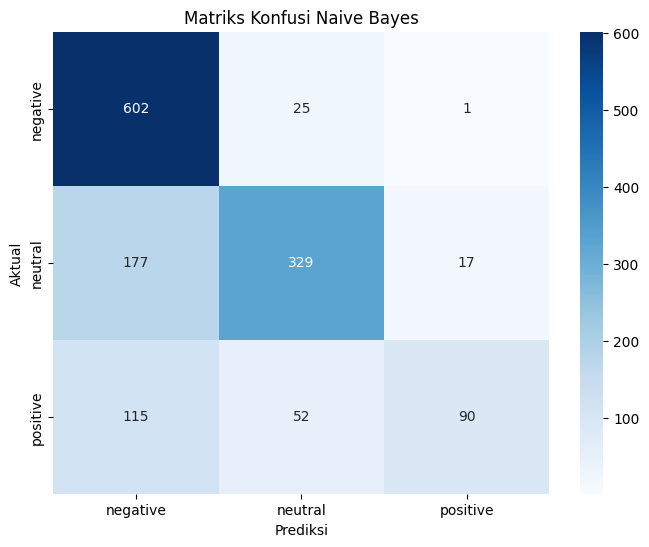


Pelabelan seluruh DataFrame dengan model Naive Bayes selesai.

Distribusi Sentimen (Label dari Naive Bayes):
sentiment_label_naive_bayes
negative    4209
neutral     2205
positive     646
Name: count, dtype: int64

10 baris pertama dengan sentimen yang diprediksi oleh Naive Bayes:
✅ STEP 5.1: Pelatihan dan evaluasi Naive Bayes selesai.


In [22]:
# 📌 STEP 5.1: Melatih dan Mengevaluasi Model Naive Bayes

print("\n✅ STEP 5.1: Memulai pelatihan dan evaluasi model Naive Bayes...")

# Impor library yang diperlukan untuk Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 5.1.1: Persiapan Data untuk Naive Bayes
# Fitur (X): Teks yang sudah diproses (dari STEP 3)
X = df['step_3_normal']
# Label (y): Hasil pelabelan otomatis dari IndoBERT (model awal, dari STEP 5)
y = df['sentiment_label']

# Hapus baris dengan nilai None atau NaN di kolom teks atau label jika ada, agar Naive Bayes tidak error
# Ini penting jika ada teks yang gagal diprediksi oleh model awal, atau teks aslinya kosong
df_nb = df.dropna(subset=['step_3_normal', 'sentiment_label']).copy()
X_nb = df_nb['step_3_normal']
y_nb = df_nb['sentiment_label']

# Pastikan ada data yang cukup setelah dropna
if len(df_nb) == 0:
    print("WARNING: Tidak ada data yang tersisa setelah membersihkan nilai None/NaN untuk Naive Bayes. Tidak dapat melatih model Naive Bayes.")
else:
    # Pisahkan data menjadi set pelatihan dan pengujian untuk Naive Bayes
    X_train, X_test, y_train, y_test = train_test_split(X_nb, y_nb, test_size=0.2, random_state=42, stratify=y_nb)

    print(f"Jumlah data pelatihan Naive Bayes: {len(X_train)}")
    print(f"Jumlah data pengujian Naive Bayes: {len(X_test)}")

    # 5.1.2: Vectorization Teks (TF-IDF)
    # Gunakan TfidfVectorizer untuk mengubah teks menjadi fitur numerik
    vectorizer = TfidfVectorizer(max_features=5000) # Batasi jumlah fitur untuk efisiensi dan relevansi
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    print("Text vectorization selesai.")

    # 5.1.3: Melatih Model Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vectorized, y_train)

    print("Model Naive Bayes berhasil dilatih.")

    # 5.1.4: Evaluasi Model Naive Bayes
    y_pred = nb_model.predict(X_test_vectorized)

    print("\nLaporan Klasifikasi Naive Bayes:")
    print(classification_report(y_test, y_pred))

    print("\nMatriks Konfusi Naive Bayes:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title('Matriks Konfusi Naive Bayes')
    plt.show()

    # 5.1.5: Terapkan Model Naive Bayes ke Seluruh DataFrame Asli
    # Pastikan vectorizer yang sama digunakan untuk seluruh data
    df['step_3_normal'] = df['step_3_normal'].fillna('')
    # Anda bisa menambahkan kolom ini atau tidak, tergantung kebutuhan Anda untuk menyimpan vektor teks
    # df['step_3_normal_vectorized'] = list(vectorizer.transform(df['step_3_normal']))
    df['sentiment_label_naive_bayes'] = nb_model.predict(vectorizer.transform(df['step_3_normal']))

    print("\nPelabelan seluruh DataFrame dengan model Naive Bayes selesai.")
    print("\nDistribusi Sentimen (Label dari Naive Bayes):")
    print(df['sentiment_label_naive_bayes'].value_counts())
    print("\n10 baris pertama dengan sentimen yang diprediksi oleh Naive Bayes:")
    df[['full_text', 'step_3_normal', 'sentiment_label', 'sentiment_label_naive_bayes']].head(10)

    # Menyimpan model Naive Bayes dan vectorizer jika diperlukan di kemudian hari
    import joblib
    joblib.dump(nb_model, '/content/drive/MyDrive/DATA/naive_bayes_model.pkl')
    joblib.dump(vectorizer, '/content/drive/MyDrive/DATA/tfidf_vectorizer.pkl')

print("✅ STEP 5.1: Pelatihan dan evaluasi Naive Bayes selesai.")


# **🪄 Step 6: Prediksi dengan Model Naive Bayes**

In [23]:
# 📌 STEP 6.1: Contoh Prediksi dengan Model Naive Bayes yang Dilatih ---
print("\n--- Contoh Prediksi dengan Model Naive Bayes yang Dilatih ---")
sample_texts = [
    "program ini sangat bagus dan sesuai dengan tujuan pertumbuhan indonesia.",
    "takut banget malah jadi sarang koruptor",
    "bagus, upaya memajukan ekonomi indonesia"
]

# FUNGSI UNTUK MEMPROSES TEKS SAMPEL
# Fungsi ini tetap menghasilkan teks lengkap dengan stopword/stemming untuk Naive Bayes.
def preprocess_sample_text(text):
    if not isinstance(text, str):
        return ""

    # Tahap 1: Pembersihan Awal (Mirip tahap1_clean)
    cleaned = tahap1_clean(text)

    # Tahap 2: Lowercase
    lowered = cleaned.lower()

    # Tahap 3: Normalisasi Kata Tidak Baku (Mirip tahap3_normalize)
    normalized = tahap3_normalize(lowered)

    # Tahap 4: Tokenisasi, Stopword Removal, dan Stemming (Mirip logika apply_advanced_preprocessing_global)
    tokens = word_tokenize(normalized)
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return ' '.join(stemmed_tokens)

preprocessed_sample_texts = [preprocess_sample_text(text) for text in sample_texts]

# Ekstraksi fitur untuk teks baru
sample_texts_tfidf = vectorizer.transform(preprocessed_sample_texts)

# Prediksi sentimen
predicted_sentiments = nb_model.predict(sample_texts_tfidf)

for i, text in enumerate(sample_texts):
    print(f"Original Text: '{text}'")
    print(f"Processed Text for NB: '{preprocessed_sample_texts[i]}'")
    print(f"Predicted Sentiment (Naive Bayes): {predicted_sentiments[i]}\n")



--- Contoh Prediksi dengan Model Naive Bayes yang Dilatih ---
Original Text: 'program ini sangat bagus dan sesuai dengan tujuan pertumbuhan indonesia.'
Processed Text for NB: 'program sangat sesuai tuju tumbuh indonesia'
Predicted Sentiment (Naive Bayes): positive

Original Text: 'takut banget malah jadi sarang koruptor'
Processed Text for NB: 'takut malah sarang koruptor'
Predicted Sentiment (Naive Bayes): negative

Original Text: 'bagus, upaya memajukan ekonomi indonesia'
Processed Text for NB: 'upaya maju ekonomi indonesia'
Predicted Sentiment (Naive Bayes): positive



In [24]:
# 📌 STEP 6.2: Simpan Hasil Akhir ---
output_filename = '/content/drive/MyDrive/DATA/danantara_full_sentiment_analysis_naive_bayes.csv'
df.to_csv(output_filename, index=False)
print(f"\nDataFrame lengkap dengan hasil analisis sentimen disimpan ke: {output_filename}")

print("\nAnalisis sentimen menggunakan IndoBERT (pre-trained) dan Naive Bayes telah selesai!")



DataFrame lengkap dengan hasil analisis sentimen disimpan ke: /content/drive/MyDrive/DATA/danantara_full_sentiment_analysis_naive_bayes.csv

Analisis sentimen menggunakan IndoBERT (pre-trained) dan Naive Bayes telah selesai!
